In [1]:
using Pipe
using Iterators
using DataStructures

In [2]:
function loadphrases(filename)
    (@pipe readall(filename) |> split(_,'\n'))[1:end-1];
end

function load_phrases_and_embeddings(base_filename)
    phrases = loadphrases(base_filename * ".phrases.txt")
    ps = readcsv(base_filename * ".csv")
    @assert size(ps,1)==length(phrases)
    phrases,ps
end

load_phrases_and_embeddings (generic function with 1 method)

In [ ]:
#phrase_range = 14380:16000  #old testerment14380:40069
#ps = readcsv("results/gutten.csv")[phrase_range,:]
#phrases = loadphrases("results/gutten.phrases.txt") [phrase_range]

In [54]:
phrases,ps = load_phrases_and_embeddings("results/boy_mom_turtle")

(SubString{ASCIIString}["the boy destroyed the house .","the house was destroyed by the boy .","the house was demolished by the boy .","the young man destroyed the residential building .","the boy was responsible for the house 's destruction .","the mother repaired the house .","the house was repaired by the mother .","the house was rebuilt by the mother .","the mom repaired the residential building .","the mother was responsible for the house 's restoration .","turtles have shells .","turtles are green","turtles live in the ocean","sea turtles only come to land to lay eggs .","turtles are not very fast"],
15x100 Array{Float64,2}:
 -0.17997    -0.13223   -0.022656  …  -0.10334     0.023363  -0.18997 
 -0.067462   -0.081591  -0.055153     -0.12333    -0.08767   -0.1175  
 -0.072964   -0.088562  -0.058637     -0.12755    -0.057626  -0.12589 
 -0.011684   -0.10501   -0.098306      0.0026428   0.05604   -0.21943 
 -0.051426   -0.10299   -0.095373     -0.081584   -0.061373  -0.17749 
 -0.18

In [68]:
phrases

15-element Array{SubString{ASCIIString},1}:
 "the boy destroyed the house ."                            
 "the house was destroyed by the boy ."                     
 "the house was demolished by the boy ."                    
 "the young man destroyed the residential building ."       
 "the boy was responsible for the house 's destruction ."   
 "the mother repaired the house ."                          
 "the house was repaired by the mother ."                   
 "the house was rebuilt by the mother ."                    
 "the mom repaired the residential building ."              
 "the mother was responsible for the house 's restoration ."
 "turtles have shells ."                                    
 "turtles are green"                                        
 "turtles live in the ocean"                                
 "sea turtles only come to land to lay eggs ."              
 "turtles are not very fast"                                

In [29]:
using PyCall

In [34]:

@pyimport sklearn
@pyimport sklearn.mixture as sklm

In [ ]:
gmm=sklm.GMM(n_components=10, covariance_type="full", n_init=25) 
gmm[:fit](ps)
gmm[:weights_]'


In [ ]:
ENV["LINES"]=1000
keys(gmm) |> collect

In [ ]:
function show_clusters_gmm(gmm,xs, words)
    scores = gmm[:score](xs)
    order = sort([1:length(scores);], by=ii->scores[ii], rev=true)
    clusters = DefaultDict(Int, Vector{String}, ()->String[])
    for ii in order
        word = words[ii]
        cluster =  gmm[:predict](xs[ii,:])[1]
        push!(clusters[cluster], word)
    end
    
    for cluster in keys(clusters)
        println("** $cluster **")
        for word in clusters[cluster]
            println(" - ", word)
        end
        println()
    end
    clusters
end
clusters = show_clusters_gmm(gmm, ps, phrases)

In [36]:
@pyimport sklearn.cluster as skl_cluster

In [ ]:
bandwidth = skl_cluster.estimate_bandwidth(ps, quantile=0.05)
ms = skl_cluster.MeanShift(bandwidth=bandwidth, bin_seeding=false, min_bin_freq=1)

println(ms[:fit](ps))
println( ms[:labels_] |> unique |> sort)

In [40]:
function show_clusters(model,words, labels)
    clusters = DefaultDict(Int, Vector{String}, ()->String[])
    for ii in 1:length(words)
        word = words[ii]
        cluster =  labels[ii]
        push!(clusters[cluster], word)
    end
    
    for cluster in keys(clusters)
        println("** $cluster **")
        for word in clusters[cluster]
            println(" - ", word)
        end
        println()
    end
    clusters
end



show_clusters (generic function with 1 method)

In [ ]:
show_clusters(ms,phrases, ms[:labels_])

In [25]:
using Distances
push!(LOAD_PATH, "../recursive_embeddings/")
import WordEmbeddings.cosine_sim

In [55]:
pps = ps'
cosine_sim = Number[WordEmbeddings.cosine_sim(pps[:,ii],pps[:,jj]) for ii in 1:size(pps,2), jj in 1:size(pps,2)];
#dot_sim = -1*Number[dot(pps[:,ii],pps[:,jj]) for ii in 1:size(pps,2), jj in 1:size(pps,2)];
#cosine_sim2 = -pairwise(CosineDist(),pps)
manhatten_sim = - pairwise(Cityblock(), pps)
euclidean_sim = -pairwise(Euclidean(),pps)


15x15 Array{Float64,2}:
 -0.0       -1.05077   -1.05045   -0.991302  …  -1.8408   -1.5335   -1.68596 
 -1.05077   -0.0       -0.120067  -1.27955      -1.71403  -1.62171  -1.61217 
 -1.05045   -0.120067  -0.0       -1.28119      -1.71528  -1.6188   -1.62552 
 -0.991302  -1.27955   -1.28119   -0.0          -1.68545  -1.6453   -1.57807 
 -0.90966   -0.611624  -0.622451  -1.36977      -1.76716  -1.58522  -1.65031 
 -0.524454  -0.997893  -0.99661   -1.00979   …  -1.8795   -1.5438   -1.72034 
 -1.09277   -0.152656  -0.156324  -1.29422      -1.7114   -1.63216  -1.6194  
 -1.05775   -0.182343  -0.157807  -1.27805      -1.70396  -1.61864  -1.61417 
 -0.841219  -1.16478   -1.1662    -0.974659     -1.8514   -1.53845  -1.71581 
 -1.04671   -0.459857  -0.465588  -1.3634       -1.79249  -1.61489  -1.67802 
 -1.39138   -1.2004    -1.21366   -1.26896   …  -1.34247  -1.44871  -1.16905 
 -1.6119    -1.56615   -1.57942   -1.46903      -1.0968   -1.38884  -0.834964
 -1.8408    -1.71403   -1.71528   -1.685

In [56]:
#@pipe manhatten_sim |> find(_.==0.0) |> map(ii->ind2sub(size(manhatten_sim),ii), _) |> map(println,_);

In [57]:
affinity = pycall(pybuiltin("intern"),PyObject, "precomputed")
affprop = skl_cluster.AffinityPropagation(damping=0.6,affinity=affinity)

affprop[:fit_predict](manhatten_sim)
centers = affprop[:cluster_centers_indices_] + 1 #julia indexing
for phrase in phrases[centers]
    println(phrase)
end

the mother repaired the house .
the house was repaired by the mother .
turtles are green
sea turtles only come to land to lay eggs .


In [58]:
show_clusters(affprop,phrases, affprop[:labels_])

** 0 **
 - the boy destroyed the house .
 - the young man destroyed the residential building .
 - the mother repaired the house .
 - the mom repaired the residential building .

** 2 **
 - turtles have shells .
 - turtles are green
 - turtles live in the ocean
 - turtles are not very fast

** 3 **
 - sea turtles only come to land to lay eggs .

** 1 **
 - the house was destroyed by the boy .
 - the house was demolished by the boy .
 - the boy was responsible for the house 's destruction .
 - the house was repaired by the mother .
 - the house was rebuilt by the mother .
 - the mother was responsible for the house 's restoration .



DefaultDict{Int64,Array{String,1},Function} with 4 entries:
  0 => String["the boy destroyed the house .","the young man destroyed the resi…
  2 => String["turtles have shells .","turtles are green","turtles live in the …
  3 => String["sea turtles only come to land to lay eggs ."]
  1 => String["the house was destroyed by the boy .","the house was demolished …

In [ ]:
count,index = findmax(clustercounts)
(affprop[:labels_].=62) |> countnz

In [ ]:
cdic = {center=>countnz(affprop[:labels_].==center) for center in (affprop[:labels_] |>unique)}
kcounts =sort(cdic |> collect, by=kc->kc[2])
most_common_cluster0 = kcounts[end-1][1]
phrase_ind0 = affprop[:cluster_centers_indices_][most_common_cluster0]
println("**",phrases[phrase_ind0+1],"**")

phrases_in_common_cluster0 = find([(affprop[:labels_].==most_common_cluster0)])
@pipe phrases[phrases_in_common_cluster0+1] |> map(println,_);

In [ ]:
size(ps)

In [ ]:
help(maximum)

In [ ]:
using Gadfly
clustercounts = [countnz(affprop[:labels_].==center) for center in (affprop[:labels_] |>unique)]
plot(x=clustercounts, Geom.histogram, Guide.xlabel("Cluster Size"), Guide.ylabel("Number of Clusters") )

In [ ]:
using Clustering

In [ ]:
affprop_j = affinityprop(similarities, damp=0.25)
#@assert(affprop_j.converged)
for ii in affprop_j.exemplars
    println(phrases[ii])
end

In [59]:
using MultivariateStats

pca = fit(PCA, ps'; maxoutdim=2)


Y = transform(pca, ps')'


15x2 Array{Float64,2}:
  0.383051    0.526424 
  0.46722    -0.358004 
  0.475792   -0.354294 
  0.0138798   0.617813 
  0.455946   -0.274721 
  0.442395    0.51804  
  0.463449   -0.397638 
  0.462155   -0.362917 
  0.293226    0.677424 
  0.516584   -0.333754 
 -0.415497   -0.157721 
 -0.963489   -0.0490135
 -1.0637     -0.279937 
 -0.54689     0.369652 
 -0.984126   -0.141355 

In [50]:
using TSne
#Y = tsne(ps, no_dims = 2, initial_dims = -1, max_iter = 1000, perplexity = 30.0)
Y = tsne(ps, 2,  -1, 2000, 20.0)

Initial X Shape is : (15,100)
Computing pairwise distances...
Mean value of sigma: 3.3554432e7
Iteration 10: error is 8.14959925324176
Iteration 20: error is 7.7357932075883
Iteration 30: error is 7.982939357529283
Iteration 40: error is 12.635180858843931
Iteration 50: error is 12.900392027469822
Iteration 60: error is 13.237352057130023
Iteration 70: error is 15.064474781323568
Iteration 80: error is 13.046055837713805
Iteration 90: error is 11.365025878323891
Iteration 100: error is 11.236982496802522
Iteration 110: error is 1.3401146685367196
Iteration 120: error is 1.2408399445930955
Iteration 130: error is 1.174676713111463
Iteration 140: error is 1.120538140120426
Iteration 150: error is 1.071622070195222
Iteration 160: error is 1.0238178590672242
Iteration 170: error is 0.9785701657004324
Iteration 180: error is 0.9382409223000607
Iteration 190: error is 0.9017995101755819
Iteration 200: error is 0.866893145644039
Iteration 210: error is 0.8321156102658396
Iteration 220: error 

15x2 Array{Float64,2}:
 -1480.49     -415.806
   -62.5844  -1561.93 
    38.9273    804.338
  -499.114    -636.923
 -1104.49    -1397.78 
  -847.661    1280.46 
 -1508.29      560.958
  -553.236     204.651
   650.159     208.648
    77.1577   1776.95 
   973.7      1223.99 
  1401.03     -520.769
   934.42    -1401.51 
  1628.25      451.909
   352.216    -577.189

In [62]:
using Gadfly
using Color
set_default_plot_size(20cm, 10cm)

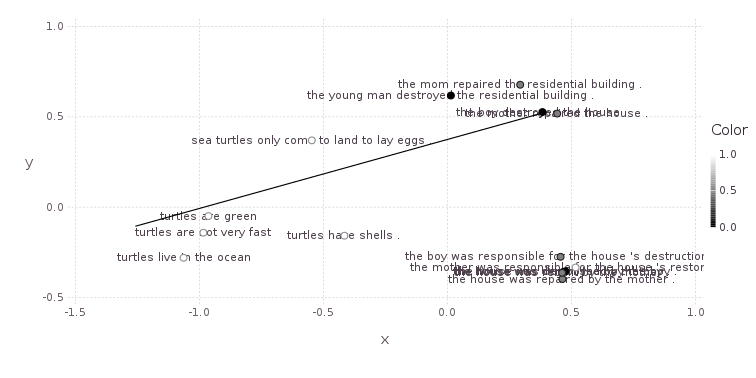

In [64]:
lbls = zeros(size(Y,1))
lbls[1:5]=0
lbls[5:10]=0.5
lbls[10:15]=1
plt = plot(x=Y[:,1], y=Y[:,2], color=lbls, label=phrases,Geom.point,
     Geom.label(position=:centered,hide_overlaps=false),
     Scale.ContinuousColorScale(p -> Color.RGB(p,p,p)))

In [65]:
draw(PNG("plt.png", 9inch, 7inch), plt)
